In [17]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
data =  pd.read_csv("data/features.csv")
labels = pd.read_csv("data/labels.csv")

data = pd.merge(data,labels)

In [3]:
data.head()

,trackID,title,tags,loudness,tempo,time_signature,key,mode,duration,vect_1,...,vect_140,vect_141,vect_142,vect_143,vect_144,vect_145,vect_146,vect_147,vect_148,genre
0,6654,Beside the Yellow Line,"i, the, to, and, a, me, it, not, in, my, is, o...",-8.539,104.341,3.0,7.0,1.0,298.73587,44.462048,...,0.000302,0.000302,0.000315,0.000297,0.000305,0.000266,0.000225,0.130826,1.071914,folk
1,5883,Ooh Na Na,"i, you, to, and, a, me, it, not, in, my, is, y...",-4.326,141.969,3.0,6.0,0.0,236.09424,46.069761,...,0.001855,0.001920,0.001950,0.001937,0.001912,0.001836,0.001740,0.148765,0.882304,soul and reggae
2,3424,Calabria 2008,"i, the, you, to, and, a, me, it, not, in, of, ...",-9.637,126.003,4.0,10.0,0.0,412.94322,40.376622,...,0.001039,0.001116,0.001166,0.001159,0.001110,0.001015,0.000895,0.116206,0.306846,soul and reggae
3,5434,Verbal Abuse (Just an American Band),"i, you, to, and, a, me, it, not, my, is, your,...",-10.969,197.625,4.0,2.0,1.0,64.78322,45.598532,...,0.000284,0.000313,0.000325,0.000324,0.000299,0.000273,0.000236,0.163738,1.247803,punk
4,516,Helen Of Troy,"i, the, to, a, me, it, not, in, is, your, we, ...",-5.369,170.008,4.0,0.0,1.0,191.97342,47.159148,...,0.000927,0.000994,0.001037,0.001051,0.001011,0.000962,0.000898,0.108193,0.366419,dance and electronica


In [4]:
data.shape

(8128, 158)

========
Features
========

* trackID: unique identifier for each song (Maps features to their labels)
* title: title of the song. Type: text.
* tags: A comma-separated list of tags representing the words that appeared in the lyrics of the song and are assigned by human annotators. Type: text / categorical.
* loudness: overall loudness in dB. Type: float / continuous.
* tempo: estimated tempo in beats per minute (BPM). Type: float / continuous.
* time_signature: estimated number of beats per bar. Type: integer.
* key: key the track is in. Type: integer/ nominal. 
* mode: major or minor. Type: integer / binary.
* duration: duration of the song in seconds. Type: float / continuous.
* vect_1 ... vect_148: 148 columns containing pre-computed audio features of each song. 
	- These features were pre-extracted (NO TEMPORAL MEANING) from the 30 or 60 second snippets, and capture timbre, chroma, and mfcc aspects of the audio. \
	- Each feature takes a continuous value. Type: float / continuous.

In [5]:
# time_signature --> to determine if to be used as numerical or categorial feature
categorical_features = {"tags", "key", "mode", "time_signature"}
other_features = {"trackID", "title"}

non_numerical_features = categorical_features.union(other_features)

numerical_features = set(data.columns[~data.columns.isin(non_numerical_features)])
vect_features = [f"vect_{i+1}" for i in range(148)]

#### Missing Values

In [6]:
# All missing value 
1 - data.dropna().shape[0]/len(data)

0.04970472440944884

Dropping of all the rows with missing value will result of lossing 5% of the data. <br>
Due to the small dataset, let's identify columns with missing values and decide if you should drop or replace the missing values  <br>

In [7]:
# "vect" features
1 - data.dropna(subset=[f"vect_{i+1}" for i in range(148)]).shape[0]/len(data)

0.039739173228346414

"vect" features missing values count for 4% of the data, missing values can be replace by the overal mean. <br>
<b>Hypothesis-1<b>: Since there is 148 features, we might to considere PCA on vect features

In [8]:
for vect in vect_features:
    data[vect].fillna(data[vect].mean(), inplace=True)

In [9]:
for column in data.columns:
    if "vect_" not in column:
        print(f"{column} - missing values: {1-data[column].count()/len(data):.3f}")

trackID - missing values: 0.000
title - missing values: 0.001
tags - missing values: 0.001
loudness - missing values: 0.001
tempo - missing values: 0.001
time_signature - missing values: 0.001
key - missing values: 0.002
mode - missing values: 0.001
duration - missing values: 0.001
genre - missing values: 0.000


For other float continues features such as loudness, tempo & duration; the missing values will be replaced by overall mean. <br>
For categorical features, missing value will be replace by the most frequent or one hot encoding and setting the to 0 <br>
For integers features, if not treated as categorical features missingn value will be replace by the median  


tags feature will be treated separately

#### Class distribustion

In [10]:
data["genre"].value_counts()/len(data)

classic pop and rock     0.207185
folk                     0.204847
metal                    0.148745
soul and reggae          0.121555
punk                     0.120694
pop                      0.089936
dance and electronica    0.064345
jazz and blues           0.042692
Name: genre, dtype: float64

<AxesSubplot:>

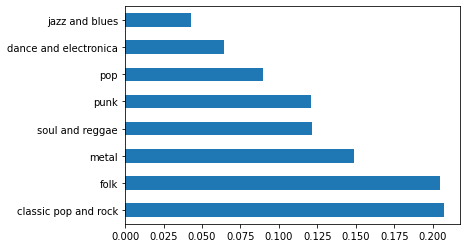

In [11]:
(data["genre"].value_counts()/len(data)).plot.barh()

Music genres are not balanced, "classic pop and rock"/ "folk" are 5 times more frequent than "jazz and blue" 
If models performs porly, try to use a Focal Loss or add weight to the class during the training phase.

#### Tags feature

In [12]:
tags = data.tags.dropna().str.lower()

In [13]:
words = set()
for row in tags.str.split(", "):
    words.update(row)
len(words)

4899

There are 4899 distincs words, therefore this collumns cannot but used as categorical even by removing the stop words. <br>
<b>Hypothesis-1</b>: embed the tags into a numerical value using solution like Doc2Vec or fasttext <br>
<b>Hypothesis-2</b>: Try to training without using this features <br>
Missing Values will be dropped

array([[-2481.57348788, -1022.5754643 ,    21.42754876],
       [-1145.59452559,  -223.13565797,   819.0718087 ],
       [ 1716.39381087,  4758.88139038,  3171.51185458],
       ...,
       [-2937.47387207, -1857.38255838,   -69.45962402],
       [ -138.54644323,  2415.93765124,   707.9724395 ],
       [-1747.59278957,  -102.58096627,  -560.53820975]])

In [19]:
scaled_vect = StandardScaler().fit_transform(data[vect_features])

In [20]:
X = PCA(n_components=3).fit_transform(scaled_vect)
pca = data.copy()
for i in range(3):
    pca[f"pca_{i+1}"] = X[:,1] 

In [21]:
pca.drop(columns=vect_features).corr()

,trackID,loudness,tempo,time_signature,key,mode,duration,pca_1,pca_2,pca_3
trackID,1.000000,0.005228,0.003894,0.003577,0.013865,-0.001746,0.016294,0.002720,0.002720,0.002720
loudness,0.005228,1.000000,0.212233,0.058110,0.041049,-0.082607,0.031135,0.339717,0.339717,0.339717
tempo,0.003894,0.212233,1.000000,-0.011361,0.004799,-0.021649,-0.038593,0.216559,0.216559,0.216559
time_signature,0.003577,0.058110,-0.011361,1.000000,-0.007261,-0.034822,0.111906,-0.050319,-0.050319,-0.050319
key,0.013865,0.041049,0.004799,-0.007261,1.000000,-0.167869,0.029725,0.000584,0.000584,0.000584
mode,-0.001746,-0.082607,-0.021649,-0.034822,-0.167869,1.000000,-0.104117,0.006544,0.006544,0.006544
duration,0.016294,0.031135,-0.038593,0.111906,0.029725,-0.104117,1.000000,0.021440,0.021440,0.021440
pca_1,0.002720,0.339717,0.216559,-0.050319,0.000584,0.006544,0.021440,1.000000,1.000000,1.000000
pca_2,0.002720,0.339717,0.216559,-0.050319,0.000584,0.006544,0.021440,1.000000,1.000000,1.000000
pca_3,0.002720,0.339717,0.216559,-0.050319,0.000584,0.006544,0.021440,1.000000,1.000000,1.000000


Most of the features are independent from each other

Using PCA to reduced the dim to 3 features so it can be plot. (Tried 2D but could not see anything)

In [22]:
labels = LabelEncoder().fit_transform(data["genre"])

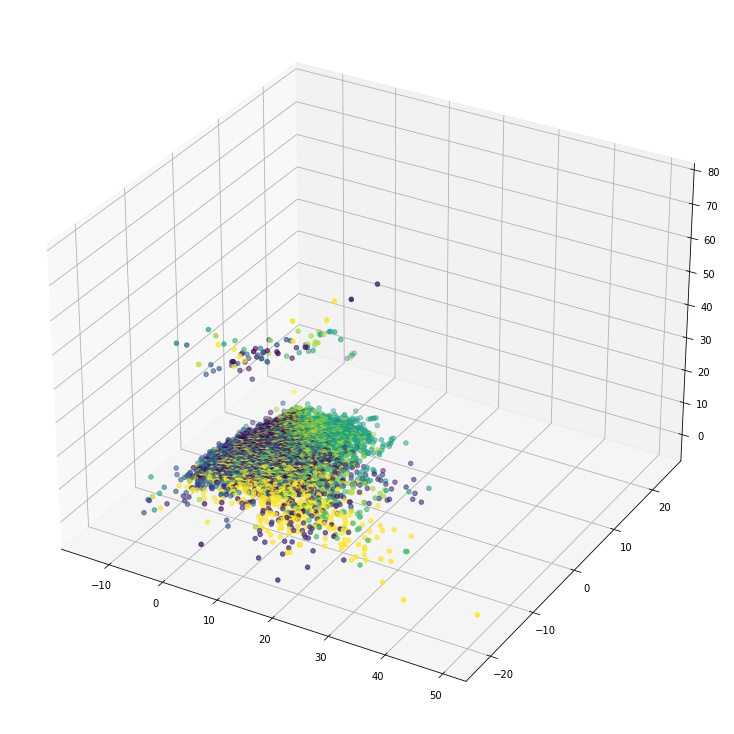

In [27]:
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig, auto_add_to_figure=False)

fig.add_axes(ax)

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels)
plt.show()

There are some zone with concentred colors (Green, yellow). <br>
We can notice there is also some outliers. <br>
<b>Hypothesis-1</b>: Using PCA to recude the number of vec, it should make the training simplier 